In [1]:
import numpy as np
import time
import sys
#
from matplotlib import pyplot as plt
%matplotlib inline

### Redshift-Space Distortions in LPT ###

Example of how to use the ```velocileptors``` code to compute the redshift-space power spectrum in LPT using the "direct" LPT method described in (https://arxiv.org/abs/2012.04636).

The first step is to import the LPT_RSD class and initialize it.  The first time this is run it can be a bit slow, but once this has been run the first time on a given platform you can save the 'wisdom' file that FFTW uses and this will speed up further executions (e.g. using the `export_wisdom` method of MomentExpansion).

Let's start with the LPT code:

In [2]:
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD

We will need a linear theory power spectrum to build the LPT model from.  Usually this would be generated by calling CAMB or CLASS, which can also provide the growth factors and growth rates.  Here we will use a pre-computed P(k) read from file.

In [3]:
# To match the plots in Chen, Vlah & White (2020) let's
# work at z=0.8, and scale our initial power spectrum
# to that redshift:
z,D,f      = 0.8, 0.6819, 0.8076
klin,plin  = np.loadtxt("pk.dat",unpack=True)
plin      *= D**2

In [4]:
# Initialize the class -- with no wisdom file passed it will
# experiment to find the fastest FFT algorithm for the system.
start= time.time()
lpt = LPT_RSD(klin,plin,kIR=0.2)
print("Elapsed time: ",time.time()-start," seconds.")
# You could save the wisdom file here if you wanted.

Elapsed time:  1.5361127853393555  seconds.


We'll start with how to compute $P(k,\mu)$ given a linear theory $P(k)$ file.  `velocileptors` generally works in $h^{-1}$Mpc units, so the input $P(k)$ should have $k$ in $h\mathrm{Mpc}^{-1}$, $P(k)$ in $h^{-3}\mathrm{Mpc}^3$ and the outputs will be similarly defined.

In [5]:
# Set up some fiducial values for the parameters -- we'll use the
# same paramters as in the paper listed above.
#
# pars: the biases and counter terms.
# b1,b2,bs,b3: linear, quadratic & cubic bias parameters
# alpha0,alpha2,alpha4,alpha6: counterterms
# sn0,sn2,sn4: stochastic contributions to P(k) and sigma^2 (here labeled by powers of mu).
#
biases = [0.71,0.26,0.67,0.52]
cterms = [-3.4,-1.7,6.5,0]
stoch  = [1500.,-1900.,0]
pars   = biases + cterms + stoch
#
# Compute the wedges, here we'll just to a single mu.  Note if we
# just wanted the real-space power spectrum we could pass mu=0 to
# compute_redshift_space_power_at_mu.  The result would differ subtly
# from the real-space routines in cleft_fftw.py due to how the IR
# resummation is handled.
# As an example we'll do mu=0.5:
#
mu     = 0.5
start  = time.time()
lpt.make_ptable(f,mu)
kw, pw = lpt.combine_bias_terms_pkmu(mu,pars)
print("Elapsed time: ",time.time()-start," seconds.")

Elapsed time:  0.9808282852172852  seconds.


In [6]:
print("# First few k bins for mu=",mu)
print("# {:>10s} {:>12s}".format("k","P(k,mu)"))
for k,p in zip(kw[:10],pw[:10]):
    print("{:12.4e} {:12.4e}".format(k,p))

# First few k bins for mu= 0.5
#          k      P(k,mu)
  1.0000e-02   4.8977e+04
  1.0679e-02   4.9930e+04
  1.1404e-02   5.0755e+04
  1.2178e-02   5.1428e+04
  1.3005e-02   5.1933e+04
  1.3888e-02   5.2250e+04
  1.4831e-02   5.2360e+04
  1.5838e-02   5.2246e+04
  1.6914e-02   5.1890e+04
  1.8062e-02   5.1280e+04


And now let's look at the (even) multipoles, $P_{\ell}(k)$:

In [7]:
# It's about as easy to compute the multipole moments up to ell=4:
# You can add AP distortions by setting apar, aperp not equal to unity
start       = time.time()
lpt.make_pltable(f,nmax=4,apar=1,aperp=1)
kl,p0,p2,p4 = lpt.combine_bias_terms_pkell(pars)
print("Elapsed time: ",time.time()-start," seconds.")

Elapsed time:  2.9997189044952393  seconds.


In [8]:
print("# First few k bins for multipoles")
print("# {:>10s} {:>12s} {:>12s} {:>12s}".format("k","P0","P2","P4"))
for k,mono,quad,hexa in zip(kl[:10],p0[:10],p2[:10],p4[:10]):
    print("{:12.4e} {:12.4e} {:12.4e} {:12.4e}".format(k,mono,quad,hexa))

# First few k bins for multipoles
#          k           P0           P2           P4
  1.0000e-02   5.3056e+04   2.8273e+04   1.8832e+03
  1.0679e-02   5.4088e+04   2.8828e+04   1.9175e+03
  1.1404e-02   5.4980e+04   2.9303e+04   1.9461e+03
  1.2178e-02   5.5708e+04   2.9684e+04   1.9679e+03
  1.3005e-02   5.6252e+04   2.9961e+04   1.9824e+03
  1.3888e-02   5.6590e+04   3.0120e+04   1.9887e+03
  1.4831e-02   5.6704e+04   3.0152e+04   1.9862e+03
  1.5838e-02   5.6572e+04   3.0045e+04   1.9741e+03
  1.6914e-02   5.6178e+04   2.9790e+04   1.9518e+03
  1.8062e-02   5.5507e+04   2.9380e+04   1.9190e+03


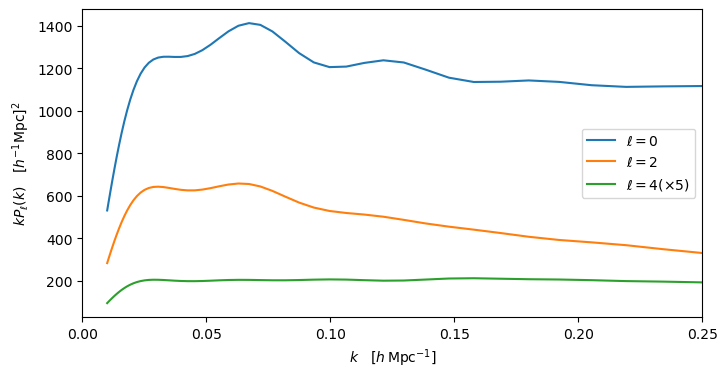

In [9]:
plt.figure(figsize=(8,4))
# We plot the multipoles and since the ell=4
# prediction is so small we multiply it by
# some convenient constant (here 5).
plt.plot(kl,  kl*p0, label=r'$\ell = 0$')
plt.plot(kl,  kl*p2, label=r'$\ell = 2$')
plt.plot(kl,5*kl*p4, label=r'$\ell = 4 (\times 5)$')
#
plt.legend()
plt.xlim(0,0.25)
plt.xlabel(r'$k\quad [h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$k P_\ell(k)\quad [h^{-1}\mathrm{Mpc}]^2$')
#
plt.show()

Note that the predictions start at $k=0.01\,h\,\mathrm{Mpc}^{-1}$.  This can be adjusted with the `kmin` argument to `make_pltable` as we will show below.

Elapsed time:  3.4778008460998535
Elapsed time:  0.0068280696868896484


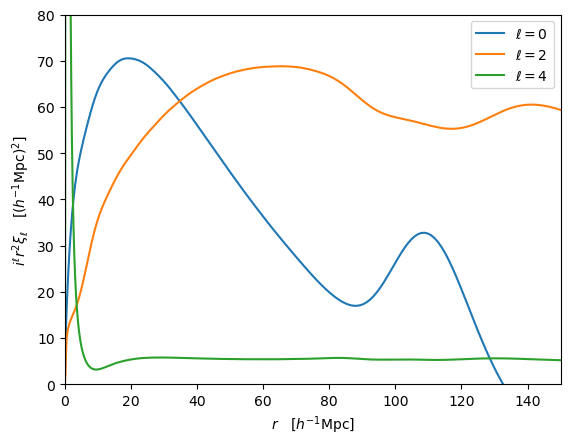

In [10]:
# You can also vary bias parameters to (almost) instantaneously produce 
# configuration space correlation function multipoles:
#
biases = [0.71,0.26,0.67,0.52]
cterms = [-3.4,-1.7,6.5,0]
stoch  = [0, 0, 0]
pars   = biases + cterms + stoch
#
# Here we increas sampling to make the Hankel transforms better
# Note that instead of specifying kmin, kmax, nk you can also specify
# a k-vector kv = (...). By being judicious in this choice, i.e.
# picking a kv that transitions from log-spacing at low-k to linear spacing
# at intermediate/high k you can drop the number of sampled points to below 50.
# (See below for an example).
#
t1 = time.time()
lpt.make_pltable(f, apar=1, aperp=1, kmin = 5e-3, kmax = 1.0, nk = 60, nmax=4)
t2 = time.time()
print('Elapsed time: ',t2-t1)
#
t1 = time.time()
xi0, xi2, xi4 = lpt.combine_bias_terms_xiell(pars)
t2 = time.time()
print('Elapsed time: ',t2-t1)
#
plt.plot(xi0[0], xi0[0]**2 * xi0[1], label=r'$\ell = 0$')
plt.plot(xi2[0],-xi2[0]**2 * xi2[1], label=r'$\ell = 2$')
plt.plot(xi4[0], xi4[0]**2 * xi4[1], label=r'$\ell = 4$')
#
plt.legend()
#
plt.xlabel(r'$r\quad [h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$i^\ell r^2 \xi_\ell\quad [(h^{-1}\mathrm{Mpc})^2]$')
#
plt.xlim(0,150)
plt.ylim(0,80)
plt.show()

Elapsed time:  0.004338741302490234


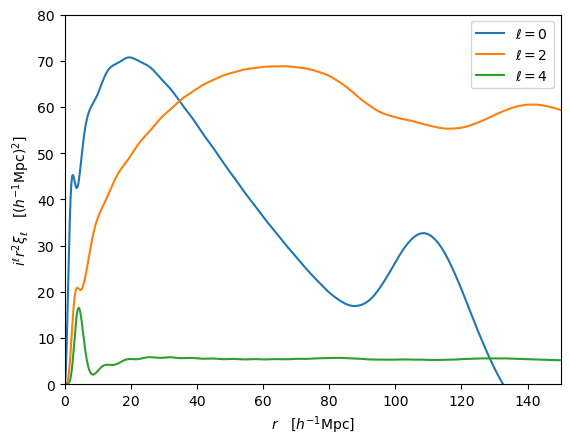

In [11]:
# There is also an alternative extrapolation scheme using Hermite polynomials instead of loginterp
# This can be more robust for situations where e.g. the quadrupole has a zero crossing
# However it also has a tendency to make oscillatory residuals at low separations... so... beta.
#
t1 = time.time()
xi0g, xi2g, xi4g = lpt.combine_bias_terms_xiell(pars, method='gauss_poly')
t2 = time.time()
print('Elapsed time: ',t2-t1)
#
plt.plot(xi0g[0], xi0g[0]**2 * xi0g[1], label=r'$\ell = 0$')
plt.plot(xi2g[0],-xi2g[0]**2 * xi2g[1], label=r'$\ell = 2$')
plt.plot(xi4g[0], xi4g[0]**2 * xi4g[1], label=r'$\ell = 4$')
#
plt.legend()
#
plt.xlabel(r'$r\quad [h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$i^\ell r^2 \xi_\ell\quad [(h^{-1}\mathrm{Mpc})^2]$')
#
plt.xlim(0,150)
plt.ylim(0,80)
plt.show()

Elapsed time:  0.007436990737915039


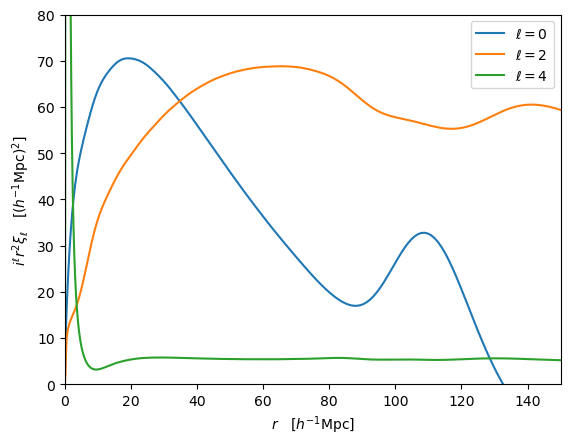

In [12]:
# And another if you want to avoid zero crossing altogethr by interpolating before it hits some
# minimum fraction of the max of p_ell
#
t1 = time.time()
xi0m, xi2m, xi4m = lpt.combine_bias_terms_xiell(pars, method='min_cut')
t2 = time.time()
print('Elapsed time: ',t2-t1)
#
plt.plot(xi0m[0], xi0m[0]**2 * xi0m[1], label=r'$\ell = 0$')
plt.plot(xi2m[0],-xi2m[0]**2 * xi2m[1], label=r'$\ell = 2$')
plt.plot(xi4m[0], xi4m[0]**2 * xi4m[1], label=r'$\ell = 4$')
#
plt.legend()
#
plt.xlabel(r'$r\quad [h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$i^\ell r^2 \xi_\ell\quad [(h^{-1}\mathrm{Mpc})^2]$')
#
plt.xlim(0,150)
plt.ylim(0,80)
plt.show()

Elapsed time:  2.527116537094116
Elapsed time:  0.009109258651733398


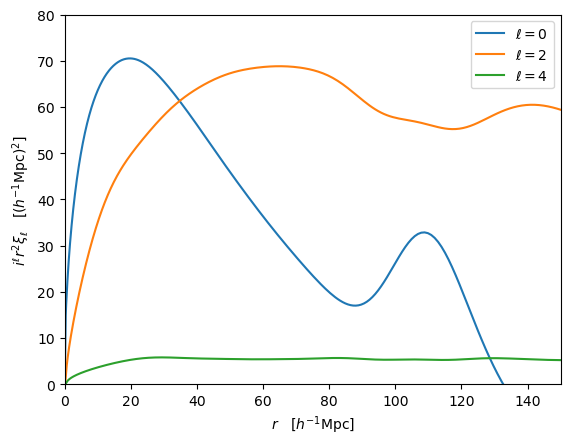

In [13]:
# You can also vary bias parameters to (almost) instantaneously produce 
# configuration space correlation function multipoles:
#
biases = [0.71,0.26,0.67,0.52]
cterms = [-3.4,-1.7,6.5,0]
stoch  = [0, 0, 0]
pars   = biases + cterms + stoch
#
# As before you can specify a k-vector kv = (...) if you want,
# let's show an example switching from log to linear spacing.
#
ntot = 40
nlow = 10
kmin = 5e-3
kmax = 0.4
kmid = 0.05
#
kl = np.concatenate( (np.logspace(np.log10(kmin),np.log10(kmid),nlow),\
                      np.linspace(kmid,kmax,ntot-nlow)[1:]) )
#
t1 = time.time()
lpt.make_pltable(f,apar=1,aperp=1,kv=kl)
t2 = time.time()
print('Elapsed time: ',t2-t1)
#
t1 = time.time()
xi0p, xi2p, xi4p = lpt.combine_bias_terms_xiell(pars)
t2 = time.time()
print('Elapsed time: ',t2-t1)
#
plt.plot(xi0p[0], xi0p[0]**2 * xi0p[1], label=r'$\ell = 0$')
plt.plot(xi2p[0],-xi2p[0]**2 * xi2p[1], label=r'$\ell = 2$')
plt.plot(xi4p[0], xi4p[0]**2 * xi4p[1], label=r'$\ell = 4$')
#
plt.legend()
#
plt.xlabel(r'$r\quad [h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$i^\ell r^2 \xi_\ell\quad [(h^{-1}\mathrm{Mpc})^2]$')
#
plt.xlim(0,150)
plt.ylim(0,80)
plt.show()

You can also specify a fixed set of bias parameters and get configuration space multipoles.

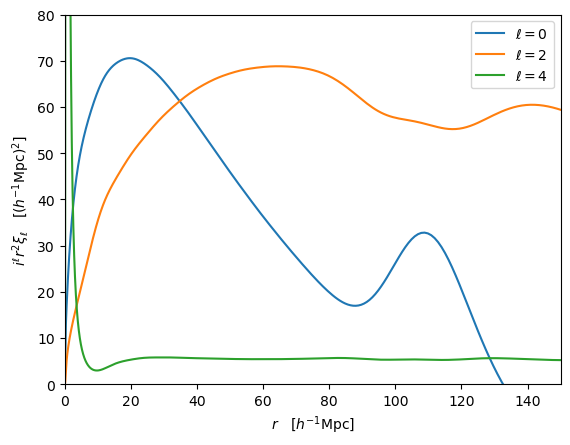

In [14]:
# Set stochastic parameters to zero because they make delta functions in config space
biases = [0.71,0.26,0.67,0.52]
cterms = [-3.4,-1.7,6.5,0]
stoch  = [0, 0, 0]
pars   = biases + cterms + stoch
# Call the xi_ell method:
xi0p, xi2p, xi4p = lpt.make_xiell_fixedbias(f,pars)
#
# This returns tuples of (argument,xi_ell) for each of
# ell=0, 2 and 4.  Each multipole has slightly
# different arguments, so you may want to interpolate
# them onto a common grid.  Usually you want to bin
# these (or something) anyway so this adds no overhead.
#
# Plot the multipoles (times r^2):
plt.plot(xi0p[0], xi0p[0]**2 * xi0p[1], label=r'$\ell = 0$')
plt.plot(xi2p[0],-xi2p[0]**2 * xi2p[1], label=r'$\ell = 2$')
plt.plot(xi4p[0], xi4p[0]**2 * xi4p[1], label=r'$\ell = 4$')
#
plt.legend()
#
plt.xlabel(r'$r\quad [h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$i^\ell r^2 \xi_\ell\quad [(h^{-1}\mathrm{Mpc})^2]$')
#
plt.xlim(0,150)
plt.ylim(0,80)
plt.show()

In [15]:
# Here's an example of some self-contained code that would compute
# the real-space matter correlation function within LPT when passed
# a linear power spectrum.  Note this pays the full cost of creating
# the class and the table.
#
def xi_lpt(klin,plin):
    """Runs velocileptors to get the real-space (matter) correlation."""
    # No bias, no counterterms and no stochastic terms.
    biases = [0.0,0.0,0.0,0.0]
    cterms = [0.0,0.0,0.0,0.0]
    stoch  = [0.0,0.0,0.0]
    pars   = biases + cterms + stoch
    # By setting f=0 we "turn off" velocities:
    lpt = LPT_RSD(klin,plin,kIR=0.3)
    lpt.make_pltable(f=0,apar=1,aperp=1,kmin=1e-3,kmax=1.0,nk=100,nmax=4)
    xi0,xi2,xi4 = lpt.combine_bias_terms_xiell(pars)
    return(xi0)
    #

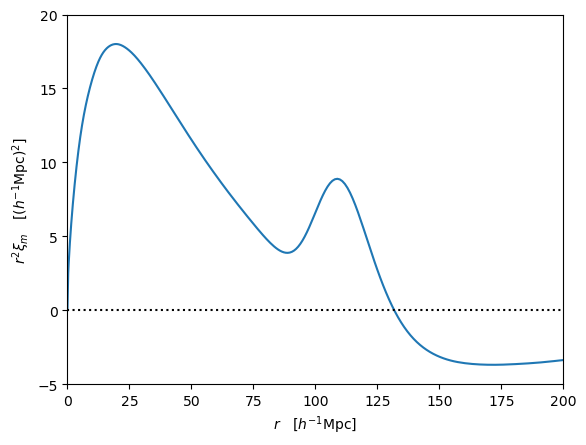

In [16]:
ximm = xi_lpt(klin,plin)
#
plt.plot(ximm[0],ximm[0]**2 * ximm[1])
plt.axhline(0.0,color='k',ls=':')
#
plt.xlabel(r'$r\quad [h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$r^2 \xi_m\quad [(h^{-1}\mathrm{Mpc})^2]$')
#
plt.xlim(0,200)
plt.ylim(-5,20)
plt.show()